In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import requests
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import sklearn.metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# Data collection

## COVID data by ZIP code

In [264]:
covid_df = pd.read_csv('data-by-modzcta.csv')
covid_df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,867,3139.82,27613.09,24,86.92,5.68,15365
1,10002,Chinatown/Lower East Side,Manhattan,3272,4343.98,75322.71,180,238.97,8.79,37434
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,1506,2790.04,53977.81,36,66.69,4.32,34890
3,10004,Financial District,Manhattan,166,5585.25,2972.12,1,33.65,5.70,2875
4,10005,Financial District,Manhattan,238,2717.76,8757.23,0,0.00,4.81,4929


The features of interest here are the zip code,the population and the case rate which is the number of cases per 100,000. 

In [265]:
covid_df=covid_df[['MODIFIED_ZCTA','COVID_CASE_RATE','POP_DENOMINATOR']]
covid_df.rename(columns={"MODIFIED_ZCTA": "ZIP", "COVID_CASE_RATE": "Case Rate",'POP_DENOMINATOR':'population'},inplace=True)
covid_df.head()

,ZIP,Case Rate,population
0,10001,3139.82,27613.09
1,10002,4343.98,75322.71
2,10003,2790.04,53977.81
3,10004,5585.25,2972.12
4,10005,2717.76,8757.23


## Including the latitude and longitude of each zip code

In [266]:
latlong_df = pd.read_csv('us-zip-code-latitude-and-longitude.csv',';')
latlong_df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,13224,Syracuse,NY,43.041866,-76.103200,-5,1,"43.041866,-76.1032"
1,13782,Hamden,NY,42.189420,-74.992190,-5,1,"42.18942,-74.99219"
2,12144,Rensselaer,NY,42.637380,-73.725870,-5,1,"42.63738,-73.72587"
3,11555,Uniondale,NY,40.754757,-73.601772,-5,1,"40.754757,-73.601772"
4,11558,Island Park,NY,40.603159,-73.655150,-5,1,"40.603159,-73.65515"


In [267]:
latlong_df=latlong_df[['Zip','Latitude','Longitude']]
latlong_df.head()

,Zip,Latitude,Longitude
0,13224,43.041866,-76.103200
1,13782,42.189420,-74.992190
2,12144,42.637380,-73.725870
3,11555,40.754757,-73.601772
4,11558,40.603159,-73.655150


In [268]:
nyc_merged=covid_df.merge(latlong_df, right_on='Zip', how='left', left_on='ZIP')
nyc_merged.drop('Zip',axis=1,inplace=True)
nyc_merged.head()

,ZIP,Case Rate,population,Latitude,Longitude
0,10001,3139.82,27613.09,40.750742,-73.99653
1,10002,4343.98,75322.71,40.717040,-73.98700
2,10003,2790.04,53977.81,40.732509,-73.98935
3,10004,5585.25,2972.12,NaN,NaN
4,10005,2717.76,8757.23,40.706019,-74.00858


In [269]:
nyc_merged.dropna(inplace=True)
nyc_merged.reset_index(inplace=True)

In [270]:
nyc_merged.drop('index',axis=1,inplace=True)

In [271]:
nyc_merged.head()
nyc_merged.dtypes

ZIP             int64
Case Rate     float64
population    float64
Latitude      float64
Longitude     float64
dtype: object

## Here I divide the different postal code neighbourhoods into 2 classes based on whether the COVID case rate is above or below the median

In [436]:
nyc_merged['Severity'] = pd.qcut(nyc_merged['Case Rate'], q=2, 
                            labels=['low', 'high'])
nyc_merged.head()

,ZIP,Case Rate,population,Latitude,Longitude,Severity
0,10001,3139.82,27613.09,40.750742,-73.99653,low
1,10002,4343.98,75322.71,40.717040,-73.98700,low
2,10003,2790.04,53977.81,40.732509,-73.98935,low
3,10005,2717.76,8757.23,40.706019,-74.00858,low
4,10006,3045.72,3381.80,40.707904,-74.01342,low


## Map of New York City with the green markers showing low severity and red markers showing high severity

In [795]:
map_NYC = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# add markers to map
for lat, lng, zipcode, severity in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['ZIP'], nyc_merged['Severity']):
    label='ZIP: {}'.format(str(zipcode))
    label = folium.Popup(label, parse_html=True)
    if severity=='low':
        marker_color='green'
    else:
        marker_color= 'red'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYC)  
    
map_NYC

## Collecting FourSquare data

In [127]:
CLIENT_ID = 'OT0FXOS2P5MJBK3XYDLZEXGWV2HRH3XOFNKG1BP0LT504DCG' # your Foursquare ID
CLIENT_SECRET = 'IJQBUSYP1TKO1EKH12LEUA0RW2H1LJ4BSDDS2LDLGKMM5BJX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OT0FXOS2P5MJBK3XYDLZEXGWV2HRH3XOFNKG1BP0LT504DCG
CLIENT_SECRET:IJQBUSYP1TKO1EKH12LEUA0RW2H1LJ4BSDDS2LDLGKMM5BJX


In [589]:
def getNearbyVenues(zipcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for ZIP, lat, lng in zip(zipcode, latitudes, longitudes):
        print(ZIP)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ZIP, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP', 
                  'ZIP Latitude', 
                  'ZIP Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [590]:
NYC_venues=getNearbyVenues(nyc_merged['ZIP'],nyc_merged['Latitude'],nyc_merged['Longitude'])

10001
10002
10003
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10069
10128
10280
10282
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10312
10314
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
11004
11101
11102
11103
11104
11105
11106
11109
11201
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11354
11355
11356
11357
11358
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11372
11373
11374
11375
11377
11378
11379
11385
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11426
11427
11428
11429
11432
11433
1143

## Onehot encoding of the venues in NYC

In [592]:
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot['ZIP'] = NYC_venues['ZIP'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_grouped = NYC_onehot.groupby('ZIP').mean().reset_index()
NYC_grouped

,ZIP,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.031579,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00
1,10002,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.0,0.0,0.0,0.0,0.02,0.010000,0.0,0.01,0.00
2,10003,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.0,0.0,0.0,0.0,0.01,0.030000,0.0,0.00,0.02
3,10005,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.01
4,10006,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.020000,0.0,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,11691,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00
170,11692,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.045455,0.0,0.00,0.00
171,11693,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00
172,11694,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00


## Grouping of the data into venue categories like restaurants, stores and entertainment

In [745]:
NYC_categorised=pd.DataFrame(NYC_grouped[['ZIP']])
restaurant_columns=[col for col in NYC_grouped.columns if 'Restaurant' in col or 'Coffee' in col]
NYC_categorised.loc[:,'Restaurants']=NYC_grouped[restaurant_columns].sum(axis=1)
store_col=[col for col in NYC_grouped.columns if 'Store' in col]
NYC_categorised.loc[:,'Store']=NYC_grouped[store_col].sum(axis=1)
entertainment_col=[col for col in NYC_grouped.columns if ('Bar'in col or'Theater' in col or 'club' in col or 'Club' in col)]
NYC_categorised.loc[:,'Entertainment']=NYC_grouped[entertainment_col].sum(axis=1)
NYC_categorised.loc[:,'Population']=nyc_merged['population']
NYC_categorised.loc[:,'COVID status']=nyc_merged['Severity']
NYC_categorised=NYC_categorised[NYC_categorised.iloc[:,1:4].sum(axis=1)>0.1]
NYC_categorised.iloc[:,1:4]=NYC_categorised.iloc[:,1:4].div(NYC_categorised.iloc[:,1:4].sum(axis=1),axis=0)

In [746]:
NYC_categorised.head()

,ZIP,Restaurants,Store,Entertainment,Population,COVID status
0,10001,0.593750,0.250000,0.156250,27613.09,low
1,10002,0.600000,0.133333,0.266667,75322.71,low
2,10003,0.653846,0.230769,0.115385,53977.81,low
3,10005,0.682927,0.121951,0.195122,8757.23,low
4,10006,0.685714,0.228571,0.085714,3381.80,low


# Building Classifiers

In [758]:
X=NYC_categorised.iloc[:,1:5]
Y=NYC_categorised.iloc[:,5]

In [791]:
dtree=DecisionTreeClassifier(max_depth=3,random_state=7)
cross_val_score(dtree,X,Y,cv=KFold(5, shuffle=True, random_state=0),scoring='f1_micro').mean()

0.6787878787878788

In [766]:
clf=GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01,
...     max_depth=3, random_state=0)
cross_val_score(clf,X,Y,cv=KFold(5, shuffle=True, random_state=4),scoring='f1_micro').mean()

0.6484848484848484

In [763]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
Xnormalised=scaler.transform(X)

In [765]:

lr=LogisticRegression(random_state=5)
cross_val_score(lr,Xnormalised,Y,cv=KFold(5, shuffle=True, random_state=5),scoring='f1_micro').mean()

0.5878787878787879

In [792]:
dtree.fit(X,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

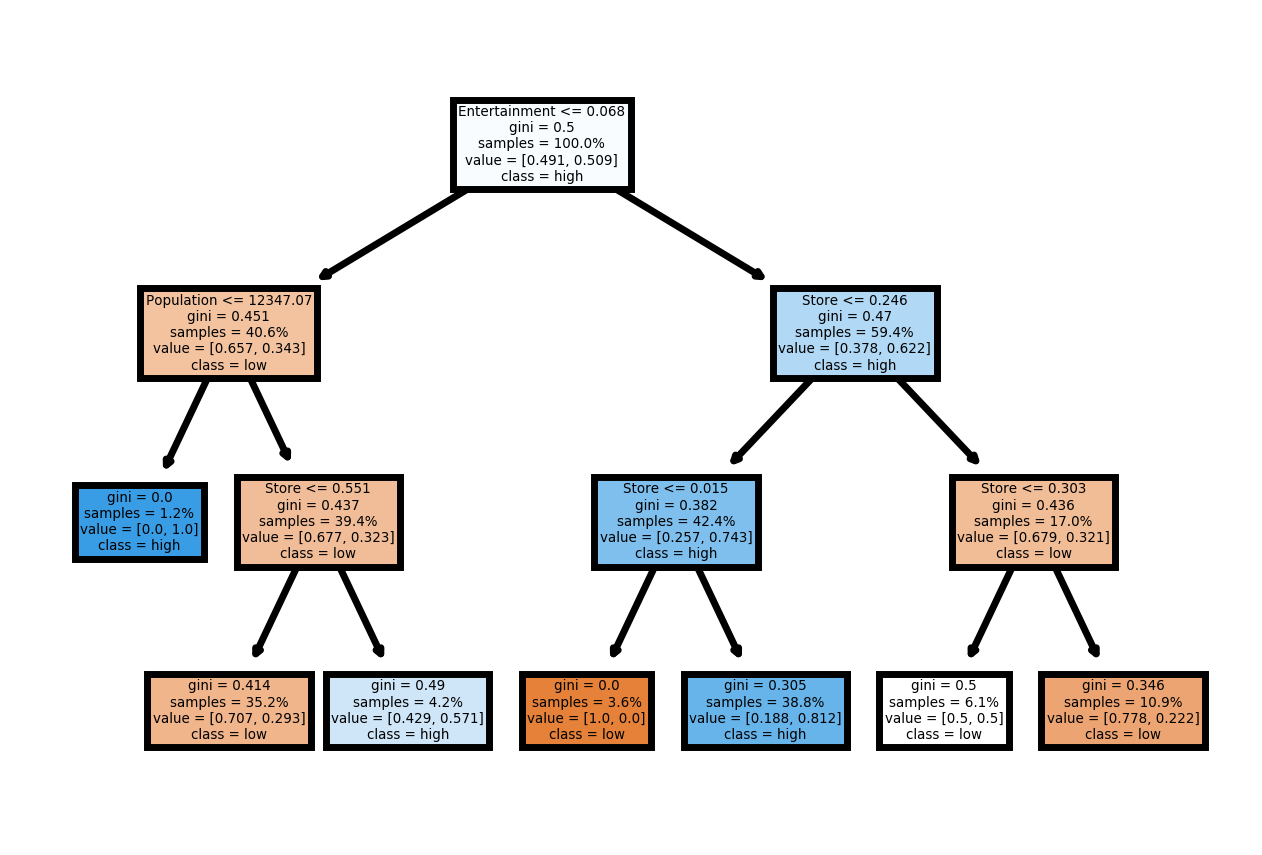

In [794]:

fn=['Restaurants','Store','Entertainment','Population']
cn=['low','high']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,2), dpi=500)
tree.plot_tree(dtree,
                feature_names = fn, 
               class_names=cn,
               filled = True,proportion=True);